# Baseball Swing

---
embed-resources: true
---

## Introduction

In this report, we will be creating a model that is used to develop a well calibrated probability model that estimates the probability of inducing a batter to swing given the characteristics of a pitch thrown, in addition to other information such as game situation, for a particular pitcher.

## Methods

In [37]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#machine learning
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from calibration import (calibration_error, plot_calibration_plot)

### Data

In [8]:
#load data 
swing_train = pd.read_parquet(
    "https://cs307.org/lab/data/swing-train.parquet",
)
swing_test = pd.read_parquet(
    "https://cs307.org/lab/data/swing-test.parquet",
)
# create X and y for train data
X_train = swing_train.drop(columns=["swing"])
y_train = swing_train["swing"]

# create X and y for test data
X_test = swing_test.drop(columns=["swing"])
y_test = swing_test["swing"]

In [9]:
# summary statistics
swing_train


,pitch_name,release_extension,release_pos_x,release_pos_y,release_pos_z,release_speed,release_spin_rate,spin_axis,plate_x,plate_z,...,balls,strikes,on_3b,on_2b,on_1b,outs_when_up,stand,sz_top,sz_bot,swing
0,Cutter,6.6,-2.76,53.86,5.81,92.6,2376.0,195.0,-0.09,2.79,...,3,1,0,0,0,1,L,3.15,1.52,1
1,Changeup,6.8,-2.87,53.74,5.66,86.3,1511.0,226.0,-1.47,1.84,...,2,1,0,0,0,1,L,3.13,1.56,0
2,Changeup,6.7,-2.83,53.82,5.68,87.9,1570.0,224.0,-1.52,2.38,...,1,1,0,0,0,1,L,3.12,1.51,0
3,Knuckle Curve,6.7,-2.70,53.78,5.78,82.4,2398.0,32.0,0.20,1.04,...,1,0,0,0,0,1,L,3.15,1.52,1
4,Cutter,6.7,-2.64,53.83,5.81,91.0,2427.0,189.0,0.89,1.65,...,0,0,0,0,0,1,L,3.12,1.51,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2659,4-Seam Fastball,6.8,-2.64,53.75,5.99,93.4,2411.0,206.0,0.59,2.91,...,0,0,0,0,0,1,L,3.50,1.81,0
2660,Slider,6.3,-2.91,54.19,5.86,87.3,2541.0,113.0,1.38,1.73,...,1,2,0,0,0,0,R,3.19,1.48,1
2661,Knuckle Curve,6.4,-2.91,54.13,5.87,84.7,2539.0,35.0,0.81,0.11,...,1,1,0,0,0,0,R,3.19,1.48,1
2662,4-Seam Fastball,6.4,-2.67,54.13,6.04,94.3,2531.0,201.0,1.05,1.79,...,0,1,0,0,0,0,R,3.03,1.48,0


There are 2,663 observations and 21 features. The response is the swing variable.

In [ ]:
#swing probability
swing_gb = swing_train.groupby('pitch_name')['swing'].agg(lambda x: (x == 1).sum())

pitch_count = swing_train.groupby('pitch_name').size()
swing_proportion = swing_gb / pitch_count
swing_gb = pd.DataFrame({
    'pitch_name': swing_proportion.index,
    'proportion': swing_proportion.values
}).reset_index(drop=True)
print(swing_gb)

        pitch_name  proportion
0  4-Seam Fastball    0.470904
1         Changeup    0.536313
2           Cutter    0.451477
3    Knuckle Curve    0.462875
4           Slider    0.496124


In [26]:
#proportion of pitches that are swung at 
np.mean(y_train == 1)

np.float64(0.47728126173488544)

The proportion of all pitches swung at are 0.47728126173488544.

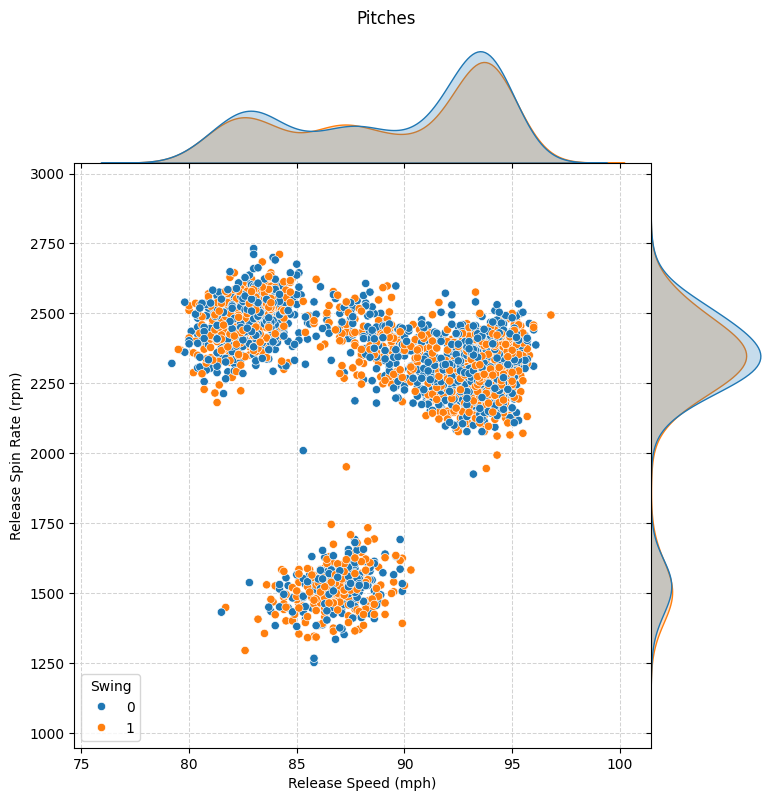

In [36]:
# exploratory visualization
plot = sns.jointplot(
    data=swing_train,
    x="release_speed",
    y="release_spin_rate",
    hue="swing",
    space=0,
    zorder=2,
)
plot.set_axis_labels(
    xlabel="Release Speed (mph)",
    ylabel="Release Spin Rate (rpm)",
)
plot.figure.suptitle(
    t="Pitches",
    y=1.02,
)
plot.ax_joint.legend(
    title="Swing",
    loc="lower left",
)
plot.ax_joint.grid(
    color="lightgrey",
    linestyle="--",
    linewidth=0.75,
    zorder=1,
)
plot.figure.set_size_inches(
    w=8,
    h=8,
)

In this plot, we can explore the relationship between the pitcher's release speed and the release spin rate compared to whether the batter swung or not. This is important because spin rate and release speed are one of the most controlled aspects of a ball pitch from the pitcher. This would have the least variability amongst all the other variables in our dataset and it could provide some insight in determining whether or not a pitcher swings. Here, we can see that there is both a mix of swung (1) and took (0) in all clusters of pitches with specified ranges of release speed and release spin rate. This might indicate that there is no discernment in determining the type of pitch a better will usually swing or took on based off of these two features alone.

### Models

In [57]:
numeric_columns = ['release_extension',
                   'release_pos_x',
                   'release_pos_y',
                   'release_pos_z',
                   'release_speed',
                   'release_spin_rate',
                   'spin_axis',
                   'plate_x',
                   'plate_z',
                   'pfx_x',
                   'pfx_z',
                   'balls',
                   'strikes',
                   'on_3b',
                   'on_2b',
                   'on_1b',
                   'outs_when_up',
                   'sz_top',
                   'sz_bot'
                   ]
categorical_columns = ['pitch_name', 'stand']
target='swing'

In [96]:
#preprocessing for numerical features
numeric_transformer = make_pipeline(
    SimpleImputer(strategy="mean"),
    StandardScaler(),
)

#preprocessing for categorical features
categorical_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="infrequent_if_exist", sparse_output=False),
)

# create general preprocessor
preprocessor = ColumnTransformer(
    transformers=[
    ('numeric', numeric_transformer, numeric_columns),
    ('categorical', categorical_transformer, categorical_columns)
    ],
    remainder="drop",
)

pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
     ('classifier', CalibratedClassifierCV(
        estimator=RandomForestClassifier(n_estimators=25),
        method='isotonic'  
    )),
])

#param grid for model
params_grid = {
    "classifier__estimator__max_depth": [5, 10, 15, 25, None],
    "classifier__estimator__criterion": ["log_loss", "gini"],  
    "classifier__method": ["isotonic", "sigmoid"],  
    "classifier__estimator__n_estimators": [10,50,100],
}

mod = GridSearchCV(
    pipeline,
    param_grid=params_grid,
    cv=5,
    n_jobs=-1,
    scoring='neg_brier_score'
)

In [97]:
# train models
mod.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['release_extension',
                                                                          'release_pos_x',
                                                                          'release_pos_y',
                                                                          'release_pos_z',
                                                                          'release_speed',
                                                                          'release_spin_rate',
                                                                          'spin_axis',
                                                                          'plate_x',
                                                                          'plate_z',
                                                                          'pfx_x',
                                                                          'pfx_z',
                                                                          'balls...
                                       ('classifier',
                                        CalibratedClassifierCV(estimator=RandomForestClassifier(n_estimators=25),
                                                               method='isotonic'))]),
             n_jobs=-1,
             param_grid={'classifier__estimator__criterion': ['log_loss',
                                                              'gini'],
                         'classifier__estimator__max_depth': [5, 10, 15, 25,
                                                              None],
                         'classifier__estimator__n_estimators': [10, 50, 100],
                         'classifier__method': ['isotonic', 'sigmoid']},
             scoring='neg_brier_score')

In [98]:
mod.best_params_

{'classifier__estimator__criterion': 'log_loss',
 'classifier__estimator__max_depth': None,
 'classifier__estimator__n_estimators': 100,
 'classifier__method': 'isotonic'}

The best model chosen out of our Calibrated Classifier cross validation is a Random Forest Classifier model with criterion log loss, no max depth set, 100 estimators, and method isotonic.

## Results

In [99]:
# report model metrics
y_pred = mod.predict(X_test)
y_pred_proba = mod.predict_proba(X_test)[:, 1]
test_ECE = calibration_error(y_test, y_pred_proba, type='expected')
test_MCE = calibration_error(y_test, y_pred_proba, type = 'max')
test_brier_score = brier_score_loss(y_test, y_pred_proba)
print(f"Test ECE: {test_ECE:.4f}")
print(f"Test MCE: {test_MCE:.4f}")
print(f"Brier Score: {test_brier_score:.4f}")

Test ECE: 0.0462
Test MCE: 0.0912
Brier Score: 0.1857


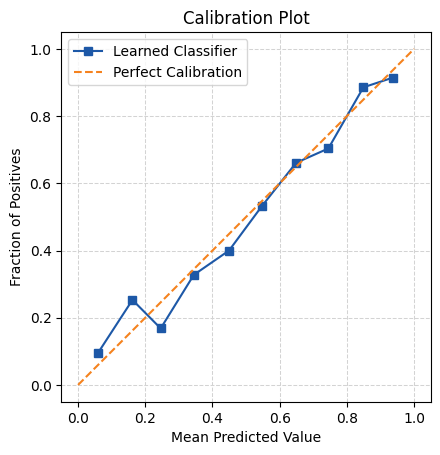

In [100]:
#summary figure
plot_calibration_plot(y_test, y_pred_proba)

Based off of our test ECE, MCE, brier score, and calibration plot, we can see that our learned classifier does a pretty good job in classifying whether or not a batter swung or took. The expected calibration error is 0.0462, the max calibration error is 0.0912, and the brier score is only around 0.1857. These values are all very small and indicates that we have very small errors in our model predictions. This plot supports this idea by showing how well our predicted values fit towards the perfect calibration on average.

In [101]:
# serialize model
from joblib import dump
dump(mod, "swing.joblib", compress=3)

['swing.joblib']

## Discussion

Based off of our chosen Random Forest classifier model of 100 estimators, uses the isotonic method, no max depth, and log loss criterion, we can see that that we end up with an expected calibration error of 0.0462, a max calibration error of 0.0912, and a brier score of 0.1857. These are all low error values and matches with our calibration plot to show that our model does a decent job at classifiying if the batter swung or took based off our features. We can use this model because it is very low risk and has little consequences if we were to predict if the batter will swing or took the ball. 